# Deteksi dan Tracking Kendaraan untuk Traffic Monitoring

Notebook ini mengimplementasikan sistem Computer Vision untuk mendeteksi,
mengenali, dan melacak kendaraan (mobil, motor, bus) menggunakan kombinasi
metode klasik (filtering, edge detection, segmentation) dan deep learning (YOLO).


## 1. Import Library

Library yang digunakan untuk pemrosesan citra, pelatihan model, evaluasi,
dan implementasi tracking kendaraan.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\USER DK\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Preprocessing Citra

Tahap preprocessing bertujuan untuk mengurangi noise dan menonjolkan
struktur kendaraan sebelum proses deteksi.
Metode yang digunakan:
- Filtering (Gaussian Blur)
- Edge Detection (Canny)


In [3]:
def preprocessing(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

## 3. Boundary Detection dan Segmentation

Boundary detection digunakan untuk mengekstraksi kontur objek,
sedangkan segmentation digunakan untuk memisahkan objek kendaraan
dari latar belakang.


In [4]:
def segmentation(edges, frame):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(frame)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(frame, mask)
    return segmented


## 4. Pra-pengolahan Data dan Konfigurasi Dataset**

Tahap pra-pengolahan dilakukan untuk memastikan dataset memenuhi kaidah ilmiah pembagian data, yaitu Train, Validation, dan Test. Pembagian ini penting untuk menghindari overfitting serta memastikan performa model dapat diuji secara objektif.

Selain itu, file konfigurasi data.yaml agar sesuai dengan struktur folder hasil pembagian data.

In [5]:
import random
import shutil
from pathlib import Path
import yaml

# Root dataset
DATASET_ROOT = Path("dataset")

TRAIN_IMG = DATASET_ROOT / "train/images"
TRAIN_LBL = DATASET_ROOT / "train/labels"
VALID_IMG = DATASET_ROOT / "valid/images"
VALID_LBL = DATASET_ROOT / "valid/labels"

TEST_IMG = DATASET_ROOT / "test/images"
TEST_LBL = DATASET_ROOT / "test/labels"

TEST_RATIO = 0.10  # 10% dari train
CLASS_NAMES = [
    "car",
    "threewheel",
    "bus",
    "truck",
    "motorbike",
    "van"
    ]

# Buat folder test
TEST_IMG.mkdir(parents=True, exist_ok=True)
TEST_LBL.mkdir(parents=True, exist_ok=True)

# Ambil image dari train
image_files = []
for ext in ["*.jpg", "*.png", "*.jpeg"]:
    image_files.extend(TRAIN_IMG.glob(ext))

random.shuffle(image_files)

num_test = int(len(image_files) * TEST_RATIO)
test_images = image_files[:num_test]

# Pindahkan image + label ke test
for img_path in test_images:
    label_path = TRAIN_LBL / f"{img_path.stem}.txt"

    if not label_path.exists():
        print(f"[WARNING] Label tidak ditemukan: {img_path.name}")
        continue

    shutil.move(str(img_path), TEST_IMG / img_path.name)
    shutil.move(str(label_path), TEST_LBL / label_path.name)

print(f"[INFO] Data test dibuat: {len(test_images)} image")

# Buat data.yaml
data_yaml = {
    "path": str(DATASET_ROOT.resolve()),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(CLASS_NAMES),
    "names": CLASS_NAMES
}

with open(DATASET_ROOT / "data.yaml", "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("[INFO] data.yaml berhasil dibuat")


[INFO] Data test dibuat: 210 image
[INFO] data.yaml berhasil dibuat


## 5. Load Model YOLO

Model YOLO pretrained digunakan sebagai dasar untuk fine-tuning
pada dataset kendaraan.


In [6]:
model = YOLO("yolov8n.pt") 

## 6. Training Model

Model dilatih untuk mengenali jenis kendaraan.
Parameter training disesuaikan agar dapat dijalankan pada CPU.


In [8]:
model.train(
    data="dataset/data.yaml",  
    epochs=20,         
    imgsz=416,
    batch=4,
    device="cpu"
)

Ultralytics 8.3.243  Python-3.12.6 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12450H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002399A0DB500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

## 7. Evaluasi Model

Evaluasi dilakukan menggunakan data validasi untuk memperoleh
precision, recall, dan mAP sebagai ukuran performa model.


In [11]:
metrics = model.val()

print("Precision :", metrics.box.p)
print("Recall    :", metrics.box.r)
print("mAP@0.5   :", metrics.box.map50)

Ultralytics 8.3.243  Python-3.12.6 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12450H)
val: Fast image access  (ping: 0.00.0 ms, read: 325.9434.3 MB/s, size: 79.9 KB)
val: Scanning D:\Kuliah\Semester5\Viskom\UAS\Kuliah\dataset\valid\labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 900/900 900.9Kit/s 0.0s
val: D:\Kuliah\Semester5\Viskom\UAS\Kuliah\dataset\valid\images\car55.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 57/57 1.6it/s 36.2s0.9ss
                   all        900       1150      0.956      0.917      0.965       0.88
                   car        182        201      0.942      0.882      0.947      0.911
            threewheel        167        227      0.976      0.914      0.974      0.872
                   bus        162        185      0.978      0.962      0.987      0.951
                 truck        123        151      0.917      0.974      0.9

## 8. Testing pada Gambar Baru

Model diuji pada citra baru yang tidak termasuk data training
untuk melihat kemampuan generalisasi.



0: 288x416 1 motorbike, 33.6ms
Speed: 1.5ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 416)


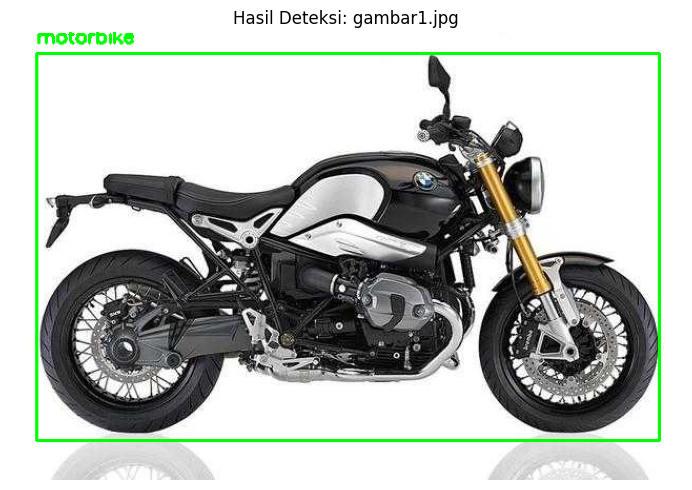


0: 320x416 1 van, 37.1ms
Speed: 1.4ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 416)


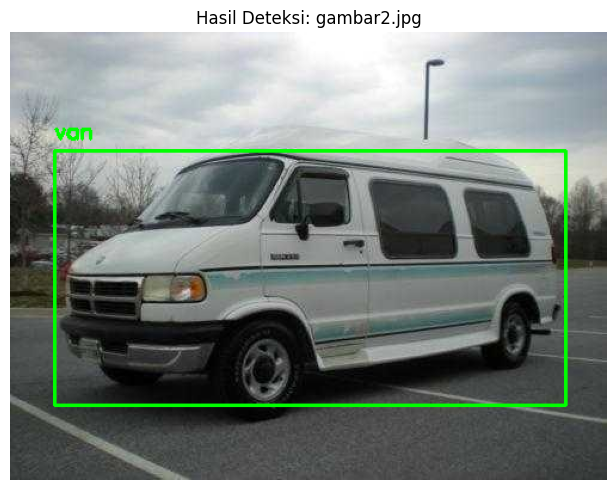


0: 320x416 1 van, 79.6ms
Speed: 1.0ms preprocess, 79.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)


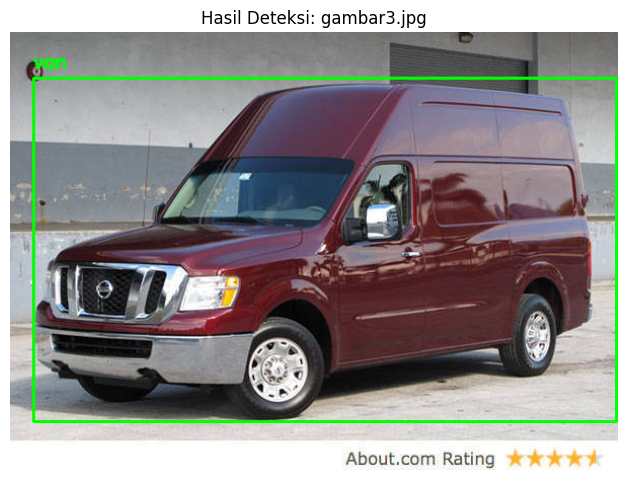


0: 416x416 1 motorbike, 44.8ms
Speed: 2.4ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)


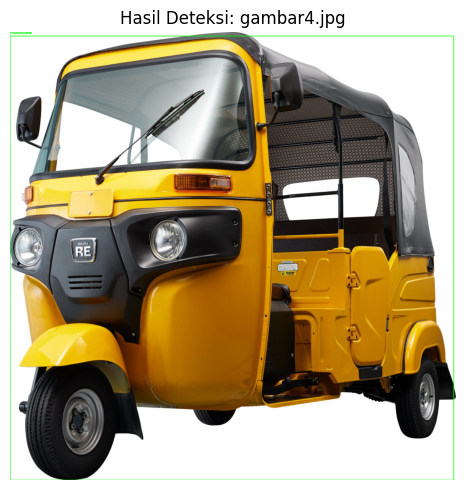


0: 256x416 1 truck, 1 van, 34.6ms
Speed: 0.9ms preprocess, 34.6ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)


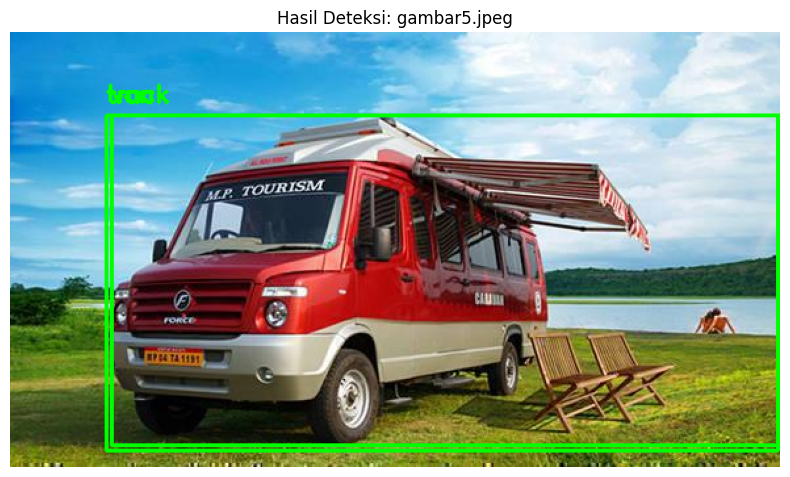


0: 288x416 1 car, 93.3ms
Speed: 1.2ms preprocess, 93.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 416)


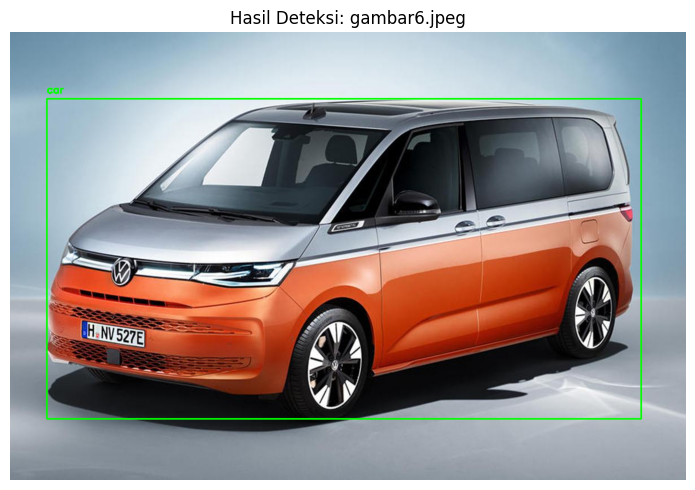


0: 224x416 1 car, 1 van, 48.4ms
Speed: 0.8ms preprocess, 48.4ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 416)



0: 320x416 1 truck, 36.5ms
Speed: 1.0ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 416)


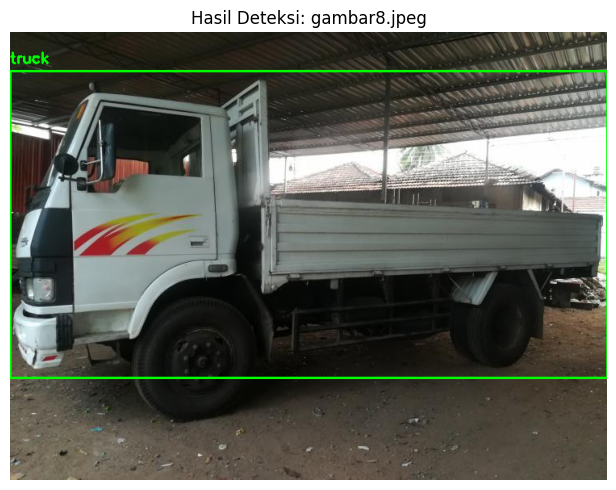


0: 320x416 1 truck, 45.6ms
Speed: 1.7ms preprocess, 45.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)


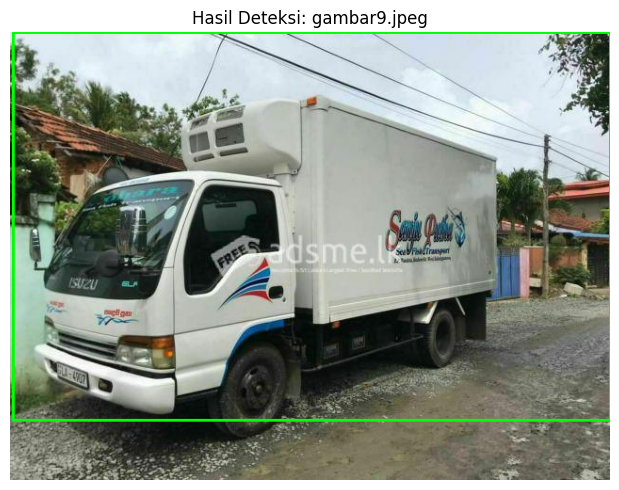


0: 320x416 1 van, 49.9ms
Speed: 1.4ms preprocess, 49.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 416)


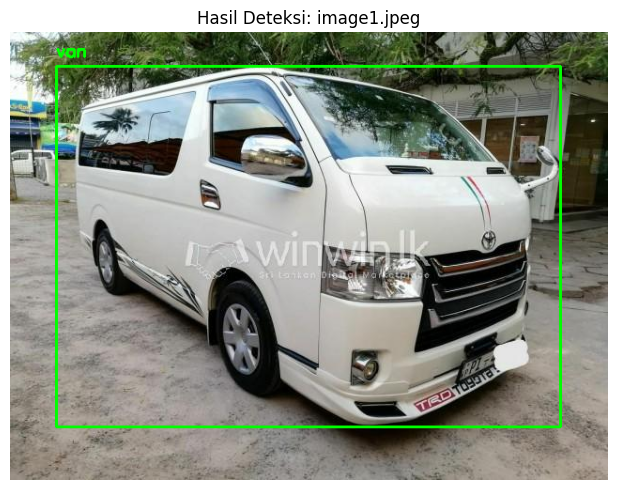


0: 288x416 1 truck, 37.0ms
Speed: 1.4ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)


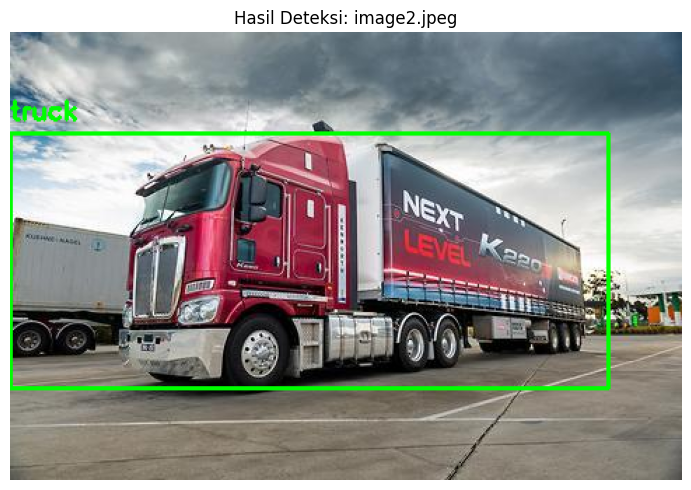


0: 416x416 1 motorbike, 50.3ms
Speed: 1.2ms preprocess, 50.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


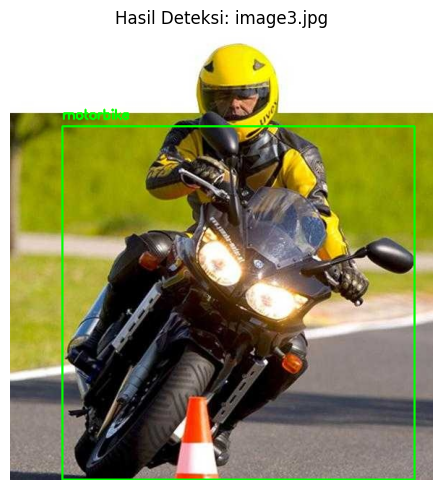

In [73]:
%matplotlib inline

import os

model = YOLO("runs/detect/train2/weights/best.pt")

image_dir = "image"

for file in sorted(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, file)

    # pastikan file (bukan folder)
    if not os.path.isfile(image_path):
        continue

    # coba baca sebagai gambar
    image = cv2.imread(image_path)

    if image is None:
        print(f"Dilewati (bukan gambar / rusak): {file}")
        continue

    # SIMPAN SALINAN GAMBAR ASLI
    output_image = image.copy()

    # preprocessing & segmentation (kode Anda)
    edges = preprocessing(image)
    segmented = segmentation(edges, image)

    results = model(segmented)

    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            label = model.names[cls]
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                output_image, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2
            )

    # KONVERSI UNTUK MATPLOTLIB
    output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 5))
    plt.imshow(output_rgb)
    plt.title(f"Hasil Deteksi: {file}")
    plt.axis("off")
    plt.tight_layout()
    plt.show(block=True)


## 9. Deteksi dan Tracking Kendaraan pada Video

Tracking digunakan untuk melacak kendaraan yang sama antar frame
dan menghitung jumlah kendaraan unik.


In [ ]:
cap = cv2.VideoCapture("traffic_video.mp4")
vehicle_ids = set()
vehicle_count = {"car": 0, "threewheel": 0, "bus": 0, "truck": 0, "motorbike": 0, "van": 0}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    edges = preprocessing(frame)
    segmented = segmentation(edges, frame)
    
    results = model.track(segmented, persist=True, device="cpu")

    for r in results:
        if r.boxes.id is None:
            continue

        for box, track_id, cls in zip(r.boxes.xyxy, r.boxes.id, r.boxes.cls):
            label = model.names[int(cls)]
            if label in vehicle_count:
                track_id = int(track_id)
                if track_id not in vehicle_ids:
                    vehicle_ids.add(track_id)
                    vehicle_count[label] += 1

                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(frame, f"{label}-{track_id}",
                            (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.6, (255,0,0), 2)

    cv2.imshow("Tracking Kendaraan", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 256x416 2 cars, 2 motorbikes, 41.5ms
Speed: 2.8ms preprocess, 41.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 car, 2 motorbikes, 41.8ms
Speed: 2.5ms preprocess, 41.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 car, 1 motorbike, 33.2ms
Speed: 1.2ms preprocess, 33.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 car, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 (no detections), 33.9ms
Speed: 1.5ms preprocess, 33.9ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 2 cars, 30.6ms
Speed: 1.4ms preprocess, 30.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 2 cars, 1 motorbike, 29.6ms
Speed: 2.3ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 car, 29.7ms
Speed: 1.1ms preprocess, 29.7ms inference, 0.7